<a href="https://colab.research.google.com/github/erickgt00/Datos-Masivos/blob/main/Analisis_Sentimiento_Twitter_Chatgpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Sentimiento para Chatgpt en Twitter

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re
from collections import Counter
from datetime import datetime

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import matplotlib.dates as mdates
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Lectura de datos
# ==============================================================================
df = pd.read_csv('chatgpt.csv')
df.head()

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet,country,photo_url,city,country_code
0,1598014056790622225,2022-11-30 18:00:15+00:00,2,0,0,0,ChatGPT: Optimizing Language Models for Dialog...,NaN,NaN,NaN,NaN
1,1598014522098208769,2022-11-30 18:02:06+00:00,12179,889,1130,3252,"Try talking with ChatGPT, our new AI system wh...",NaN,NaN,NaN,NaN
2,1598014741527527435,2022-11-30 18:02:58+00:00,2,0,0,1,ChatGPT: Optimizing Language Models for Dialog...,NaN,https://pbs.twimg.com/media/Fi1J8HbWAAMv_yi.jpg,NaN,NaN
3,1598015493666766849,2022-11-30 18:05:58+00:00,561,8,25,66,"THRILLED to share that ChatGPT, our new model ...",NaN,https://pbs.twimg.com/media/Fi1Km3WUYAAfzHS.jpg,NaN,NaN
4,1598015509420994561,2022-11-30 18:06:01+00:00,1,0,0,0,"As of 2 minutes ago, @OpenAI released their ne...",NaN,NaN,NaN,NaN


In [3]:
# Se seleccionan y renombran las columnas de interés
tweets = df[['created_at', 'tweet','tweet_id']]
tweets.columns = ['fecha', 'texto','id']

# Parseo de fechas
tweets['fecha'] = pd.to_datetime(tweets['fecha'], infer_datetime_format=True)
tweets['fecha'] = tweets['fecha'].dt.strftime('%Y-%m-%d')
tweets.head(3)

,fecha,texto,id
0,2022-11-30,ChatGPT: Optimizing Language Models for Dialog...,1598014056790622225
1,2022-11-30,"Try talking with ChatGPT, our new AI system wh...",1598014522098208769
2,2022-11-30,ChatGPT: Optimizing Language Models for Dialog...,1598014741527527435


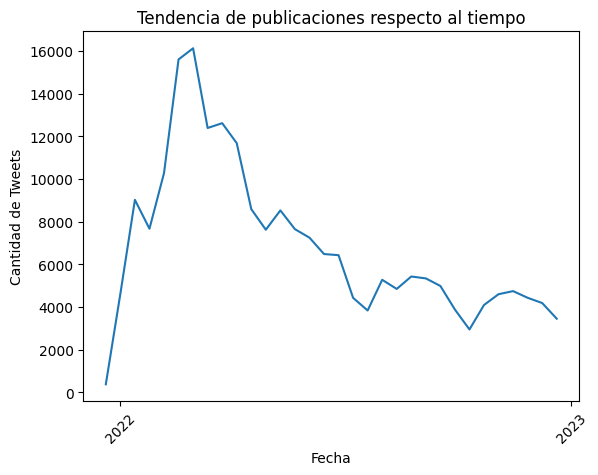

In [4]:
# Distribución temporal de los tweets
# ==============================================================================
conteo_tweets = Counter(tweets.fecha)

# Obtener las fechas y la cantidad de tweets
fechas_unicas = sorted(conteo_tweets.keys())
cantidad_tweets = [conteo_tweets[fecha] for fecha in fechas_unicas]
fechas_unicas = [datetime.strptime(fecha, "%Y-%m-%d") for fecha in fechas_unicas]

# Crear el gráfico
plt.plot(fechas_unicas, cantidad_tweets)

# Configurar el formateo del eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xlabel('Fecha')
plt.ylabel('Cantidad de Tweets')
plt.title('Tendencia de publicaciones respecto al tiempo')
plt.xticks(rotation=45)  # Girar las etiquetas del eje x para mayor legibilidad
plt.show()

In [5]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(texto=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'ejemplo', 'de', 'limpieza', 'de', 'texto', 'cienciadedatos', 'textmining']


In [6]:
# Se aplica la función de limpieza y tokenización a cada tweet
# ==============================================================================
tweets['texto_tokenizado'] = tweets['texto'].apply(lambda x: limpiar_tokenizar(x))
tweets[['texto', 'texto_tokenizado']].head()

,texto,texto_tokenizado
0,ChatGPT: Optimizing Language Models for Dialog...,"[chatgpt, optimizing, language, models, for, d..."
1,"Try talking with ChatGPT, our new AI system wh...","[try, talking, with, chatgpt, our, new, ai, sy..."
2,ChatGPT: Optimizing Language Models for Dialog...,"[chatgpt, optimizing, language, models, for, d..."
3,"THRILLED to share that ChatGPT, our new model ...","[thrilled, to, share, that, chatgpt, our, new,..."
4,"As of 2 minutes ago, @OpenAI released their ne...","[as, of, minutes, ago, openai, released, their..."


In [7]:
# Unnest de la columna texto_tokenizado
# ==============================================================================
tweets_tidy = tweets.explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='texto')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head(3)

,fecha,id,token
0,2022-11-30,1598014056790622225,chatgpt
0,2022-11-30,1598014056790622225,optimizing
0,2022-11-30,1598014056790622225,language


In [8]:
temp_df = pd.DataFrame(tweets_tidy.groupby("id")["token"].count())
mean_length = temp_df["token"].mean()
std_length = temp_df["token"].std()

print("Longitud media de los tweets:", mean_length)
print("Desviación de los tweets:", std_length)

Longitud media de los tweets: 19.77876174798101
Desviación de los tweets: 12.694680360625943


In [9]:
nltk.download('stopwords')
# Obtención de listado de stopwords del inglés
# ==============================================================================
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]

In [ ]:
# Pivotado de datos
# ==============================================================================
tweets_pivot = tweets_tidy.groupby(["id","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="id", values= "count")
tweets_pivot.columns.name = None

In [ ]:
# Descarga lexicon sentimientos
# ==============================================================================
lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['termino', 'sentimiento']
          )
lexicon.head()

In [ ]:
# Sentimiento promedio de cada tweet
# ==============================================================================
tweets_sentimientos = pd.merge(
                            left     = tweets_tidy,
                            right    = lexicon,
                            left_on  = "token", 
                            right_on = "termino",
                            how      = "inner"
                      )

tweets_sentimientos = tweets_sentimientos.drop(columns = "termino")

# Se suman los sentimientos de las palabras que forman cada tweet.
tweets_sentimientos = tweets_sentimientos[["fecha", "id", "sentimiento"]] \
                      .groupby(["autor", "fecha", "id"])\
                      .sum().reset_index()
tweets_sentimientos.head()